# How do package dependency network grow over time?

In this notebook we plan to investigate the dependencies in the Pypi dataset and try to look at
how they change over time.

## Loading data and importing libraries

In [1]:
%load_ext autoreload

# Auto reloading causes the kernel to reload the libraries we have
%autoreload 2

# usual imports for visualization, etc.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime

# make it reproducible
np.random.seed(0)

# show plots inline
%matplotlib inline

## Defining helper functions and defaults

In [2]:
# Helper Functions
def add_three_months(t):
    for i in range(3):
        t = add_a_month(t)
    return t
def add_a_month(t):
    return (t.replace(day=1) + datetime.timedelta(days=31)).replace(day=1)
def print_time(t):
    return t.strftime("%Y-%m-%dT%H:%M:%S")

!mkdir figs
figs_dir = 'figs/'

In [3]:
from cycler import cycler
def set_plt_rc():
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    
    font = {'family': 'serif','size': BIGGER_SIZE}
    plt.rc('font', **font)

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
    plt.rc('axes', prop_cycle=(cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                         '#bcbd22', '#17becf']) +
                           cycler(linestyle=['-', '--', ':', '-.','-', '--', ':', '-.','-', '--'])))
    
set_plt_rc()

# Transitive Dependencies

In [4]:

data_folder = '../data/'

requirements = pd.read_csv(data_folder + 'data_all.csv')
requirements.loc[:,'package_name'] = requirements.loc[:,'name']
requirements.loc[:,'requirement'] = requirements.loc[:,'deps']

requirements.loc[:,'package_name'] = requirements.loc[:,'package_name'].apply(lambda x: x.lower() if type(x)==str else x)
requirements.loc[:,'requirement'] = requirements.loc[:,'requirement'].apply(lambda x: x.lower() if type(x)==str else x)

requirements.loc[:,'date'] = requirements.loc[:,'date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

requirements.head()

,name,version,date,deps,package_name,requirement
0,0.0.1,0.0.1,2017-12-20,tensorflow,0.0.1,tensorflow
1,0.0.1,0.0.1,2017-12-20,pandas,0.0.1,pandas
2,115wangpan,0.1.0,2014-09-11,six,115wangpan,six
3,115wangpan,0.1.0,2014-09-11,beautifulsoup4,115wangpan,beautifulsoup4
4,115wangpan,0.1.0,2014-09-11,humanize,115wangpan,humanize


In [5]:
from tqdm.autonotebook import tqdm

tqdm.pandas()

/home/ubuntu/anaconda3/envs/mlse/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


# Automated Process

In [6]:
first_time = requirements['date'].min()
last_time = requirements['date'].max()
print('soonest start time:', first_time)
print('latest start time:', last_time)

soonest start time: 2005-08-27 00:00:00
latest start time: 2018-01-20 00:00:00


In [7]:
project_counts = {}
project_counts['StartDate'] = []
project_counts['EndDate'] = []
project_counts['dependent'] = []
project_counts['required'] = []

start_time = add_a_month(first_time)
end_time = add_three_months(start_time)
while end_time < last_time.replace(day=1):
    project_counts['StartDate'].append(start_time)
    project_counts['EndDate'].append(end_time)

    idxs = (requirements['date'] > start_time) & (requirements['date'] < end_time)
    subset = requirements.loc[idxs, :]
    
    dep_count = subset['package_name'].nunique()
    req_count = subset['requirement'].nunique()
    
    total_count = len(set(list(subset['package_name']) + list(subset['requirement'])))

    project_counts['dependent'].append(dep_count / total_count)
    project_counts['required'].append(req_count / total_count)


    start_time = end_time
    end_time = add_three_months(start_time)

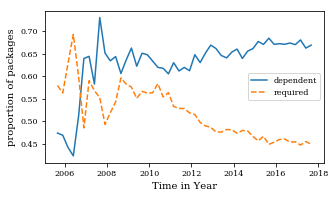

In [11]:
plt.figure(figsize=(5,2.8))

plt.plot(project_counts['StartDate'], project_counts['dependent'], label='dependent')
plt.plot(project_counts['StartDate'], project_counts['required'], label='required')
plt.legend()
plt.xlabel('Time in Year')
plt.ylabel('proportion of packages')


plt.savefig(figs_dir+'proportion-of-dependent-and-required-packages.pdf')
plt.savefig(figs_dir+'proportion-of-dependent-and-required-packages.png', dpi=300)

In [9]:
subset = requirements
dep_count = subset['package_name'].nunique()
req_count = subset['requirement'].nunique()

total_count = len(set(list(subset['package_name']) + list(subset['requirement'])))

print(dep_count / total_count)
print(req_count / total_count)

0.883478608024486
0.29248785681016704
